<a href="https://colab.research.google.com/github/stmulugheta/AI-Projects-2021/blob/main/face_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

In [ ]:
import os

# CHANGE THIS BELOW PATHS TO YOUR OWN DRIVE PATH CONTAINED YOUR FOLDER DATASET
path = '/content/gdrive/My Drive/Omdena_Competition/Data'
os.chdir(path)

# Configuration

In [ ]:
import random, re, math
import tensorflow as tf
print('Tensorflow version ' + tf.__version__)

Tensorflow version 2.7.0


# Metadata construction

In [ ]:
folder_dataset = './'

dataset_dict = {
    'race_id': {
        0: 'Sounthest and East Asian', 
        1: 'Indian', 
        2: 'Black', 
        3: 'White', 
        4: 'Middle Eastern',
        5: 'Latino_Hispanic'
    }
}

dataset_dict['race_alias'] = dict((g, i) for i, g in dataset_dict['race_id'].items())
race_dict = dataset_dict['race_alias']
race_id = dataset_dict['race_id']
race_dict

{'Black': 2,
 'Indian': 1,
 'Latino_Hispanic': 5,
 'Middle Eastern': 4,
 'Sounthest and East Asian': 0,
 'White': 3}

In [ ]:
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# Importing the required libraries for XML
import xml.etree.ElementTree as Xet

IM_WIDTH = IM_HEIGHT = 224
SEED = 777

def seed_everything(seed=SEED):
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  random.seed(seed)
  tf.random.set_seed(seed)

def get_id(file_path):
  return file_path.split('/')[1].split('.')[0]

In [ ]:
# folder metadata of each csv file
csv_1 = pd.read_csv("./unlabeled_1_false.csv")
csv_2 = pd.read_csv("./unlabeled_2_false.csv")
csv_3 = pd.read_csv("./unlabeled_3_false.csv")
csv_4 = pd.read_csv("./unlabeled_4_false.csv")
csv_5 = pd.read_csv("./unlabeled_5_false.csv")
csv_6 = pd.read_csv("./unlabeled_6_false.csv")
csv_7 = pd.read_csv("./unlabeled_7_false.csv")
csv_8 = pd.read_csv("./unlabeled_8_false.csv")
csv_9 = pd.read_csv("./unlabeled_9_false.csv")
csv_1 = pd.read_csv("./unlabeled_10_false.csv")

## Util functions

In [ ]:
def xml_to_csv(xml_path):
  cols = ['id', 'ethnicity']
  rows = list()

  # Parsing the XML file
  xmlparse = Xet.parse(xml_path)
  root = xmlparse.getroot()
  for i in root:
    id = i.find("id").text
    race = i.find("ethnicity").text
  
    rows.append({"id": id,
                 "ethnicity": race})
  
  df = pd.DataFrame(rows, columns=cols)
  return df

vgg2_train_df = xml_to_csv("./finalTrain.xml")

In [ ]:
vgg2_train_df

id ethnicity
0     n000002         3
1     n000003         3
2     n000004         3
3     n000005         3
4     n000006         4
...       ...       ...
8625  n009275         2
8626  n009276         2
8627  n009277         2
8628  n009278         2
8629  n009279         2

[8630 rows x 2 columns]

# Dataset

In [ ]:
from sklearn.utils import shuffle
from torch.utils.data import DataLoader, Dataset
from tensorflow.keras.utils import Sequence
import random

IM_WIDTH = IM_HEIGHT = 224

class Dataset(Sequence):
  def __init__(self, dataframe, vgg2_df, image_dir, batch_size):
    super().__init__()

    self.df = dataframe  # Annotation & Image's ID dataframe
    self.files = dataframe['file']  # Image's ID
    self.class_labels = [None] * len(self.files)  # Image's label
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.indexes = np.arange(len(self.df))
    self.dim = (IM_WIDTH, IM_HEIGHT, 3)
    self.vgg2_df = vgg2_df
    self.n_classes = 1

  def __len__(self):
    """Denotes the number of batch per epoch"""
    return int(np.floor(len(self.df) / self.batch_size))


  def __getitem__(self, index: int):
    # Generate indexes of a batch 
    indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]

    # Find list of image's paths
    list_people = [self.df.iloc[idx] for idx in indexes]

    # Load image & label each batch
    X, y, highest_probs, filenames, vgg2_race = self.__data_generation(list_people)

    # VGG2 race 
    return X, y, highest_probs, filenames, vgg2_race


  def load_image(self, file_name):
    # loads 1 image from dataset, returns img, original hw, resized hw
    """Load 1 image from dataset
    Input:
      index: idx to search for image's id
    Output:
      img, hw_original, hw_resized """
    # Read an image using opencv2
    img = cv2.imread(f'{self.image_dir}/{file_name}', cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR to RGB
    assert img is not None, 'Image Not Found'

    img_resize = cv2.resize(img, (IM_WIDTH, IM_HEIGHT), interpolation=cv2.INTER_AREA)
    return np.array(img_resize).astype("int")


  def __data_generation(self, list_people):
    """Generate set of data with batch_size samples""" 
    # X: (n_samples, *dim, n_channels)
    # Initialization
    X = np.empty((self.batch_size, *self.dim))
    y = np.empty((self.batch_size, self.n_classes), dtype=object)
    filenames = np.empty((self.batch_size, self.n_classes), dtype=object)
    highest_probs = np.empty((self.batch_size, self.n_classes), dtype=np.float32)
    vgg2_race = np.empty((self.batch_size, self.n_classes), dtype=object)

    # Generate data
    for i, person in enumerate(list_people):
      # Load & preprocess img
      X[i,] = self.load_image(person['file'])
      # Load target
      y[i,] = person['race']

      # Get race with highest prob
      race = person[['race']].iloc[0]
      highest_probs[i,] = person[race]

      # File names
      filenames[i,] = person['file'].split('.')[0]
      # VGG2 race
      per_id = person['file'].split('_')[0]
      try:
        vgg2_race[i,] = self.vgg2_df.loc[self.vgg2_df['id'] == per_id]['ethnicity'].values[0]
      except:
        vgg2_race[i,] = 'None'

    return X, y, highest_probs, filenames, vgg2_race


In [ ]:
csv_2

file  ... Middle Eastern
0   n008855_0006_01.jpg  ...       0.000006
1   n005076_0001_01.jpg  ...       0.000022
2   n005792_0006_01.jpg  ...       0.158076
3   n007157_0003_01.jpg  ...       0.000517
4   n005630_0002_01.jpg  ...       0.003514
..                  ...  ...            ...
94  n002826_0002_04.jpg  ...       0.000327
95  n003533_0004_01.jpg  ...       0.000360
96  n009107_0005_01.jpg  ...       0.005333
97  n005077_0001_01.jpg  ...       0.004518
98  n004489_0002_01.jpg  ...       0.298656

[99 rows x 8 columns]

In [ ]:
def collate_fn(batch):
  return tuple(zip(*batch))

def visualize_face(df, vgg2_df, face_dir, batch_size, indx):
  dataset = Dataset(df, vgg2_df, face_dir, batch_size)  

  fig, ax = plt.subplots(7, 5, figsize=(25, 25))
  ax = ax.flatten()
  images, race_labels, highest_probs, filenames, vgg2_races = dataset[indx]

  for i in range(33):  # Go through each batch 
    sample = images[i]
    height, width = sample.shape[:2]
    race = race_labels[i][0][:3]
    prob = round(float(highest_probs[i][0]), 3)
    filename = filenames[i][0][:7]
    vgg2_race = vgg2_races[i][0]

    title = f"Pred: {race}({str(prob)}), {filename}, VGG2's race: {vgg2_race}"
    ax[i].set_title(title, fontsize=10)
    ax[i].imshow(sample.astype("uint8"))  # Visualize a sample for each batch
  plt.show()

In [ ]:
# identity_meta = pd.read_csv("./vgg2_meta/identity_meta.csv", delim_whitespace=True)
# cols = [["Class_ID", "Name", "Sample_Num", "Flag", "Gender"]]
# identity_meta.columns = cols

In [ ]:
# identity_meta.to_csv("./vgg2_meta/identity_meta.csv", index=False)

In [ ]:
# folder metadata
csv_file = pd.read_csv("./unlabeled_2_false.csv")
FACE_DIR = "./2"
vgg2_train_df = xml_to_csv("./vgg2_meta/finalTrain.xml")
identity_meta = pd.read_csv("./vgg2_meta/identity_meta.csv", delim_whitespace=True)
BATCH_SIZE = 33

In [ ]:
identity_meta

Class_ID,Name,Sample_Num,Flag,Gender
0      n000001,,"14th_Dalai_Lama,","424,","0,",m
1        n000002,,"A_Fine_Frenzy,","315,","1,",f
2           n000003,,"A._A._Gill,","205,","1,",m
3        n000004,,"A._J._Buckley,","387,","1,",m
4     n000005,,"A._J._Pierzynski,","229,","1,",m
...                                          ...
9126           n009287,,"Ni_Ping,","226,","0,",f
9127       n009288,,"Song_Dandan,","252,","0,",f
9128          n009289,,"Pan_Hong,","236,","0,",f
9129      n009291,,"Stephen_Chow,","200,","0,",m
9130         n009294,,"Lang_Ping,","234,","0,",f

[9131 rows x 1 columns]

In [ ]:
len(csv_file)

99

In [ ]:
# Total number of index in "Dataset" object
dataset = Dataset(csv_file, vgg2_train_df, FACE_DIR, BATCH_SIZE)
len(dataset)

3

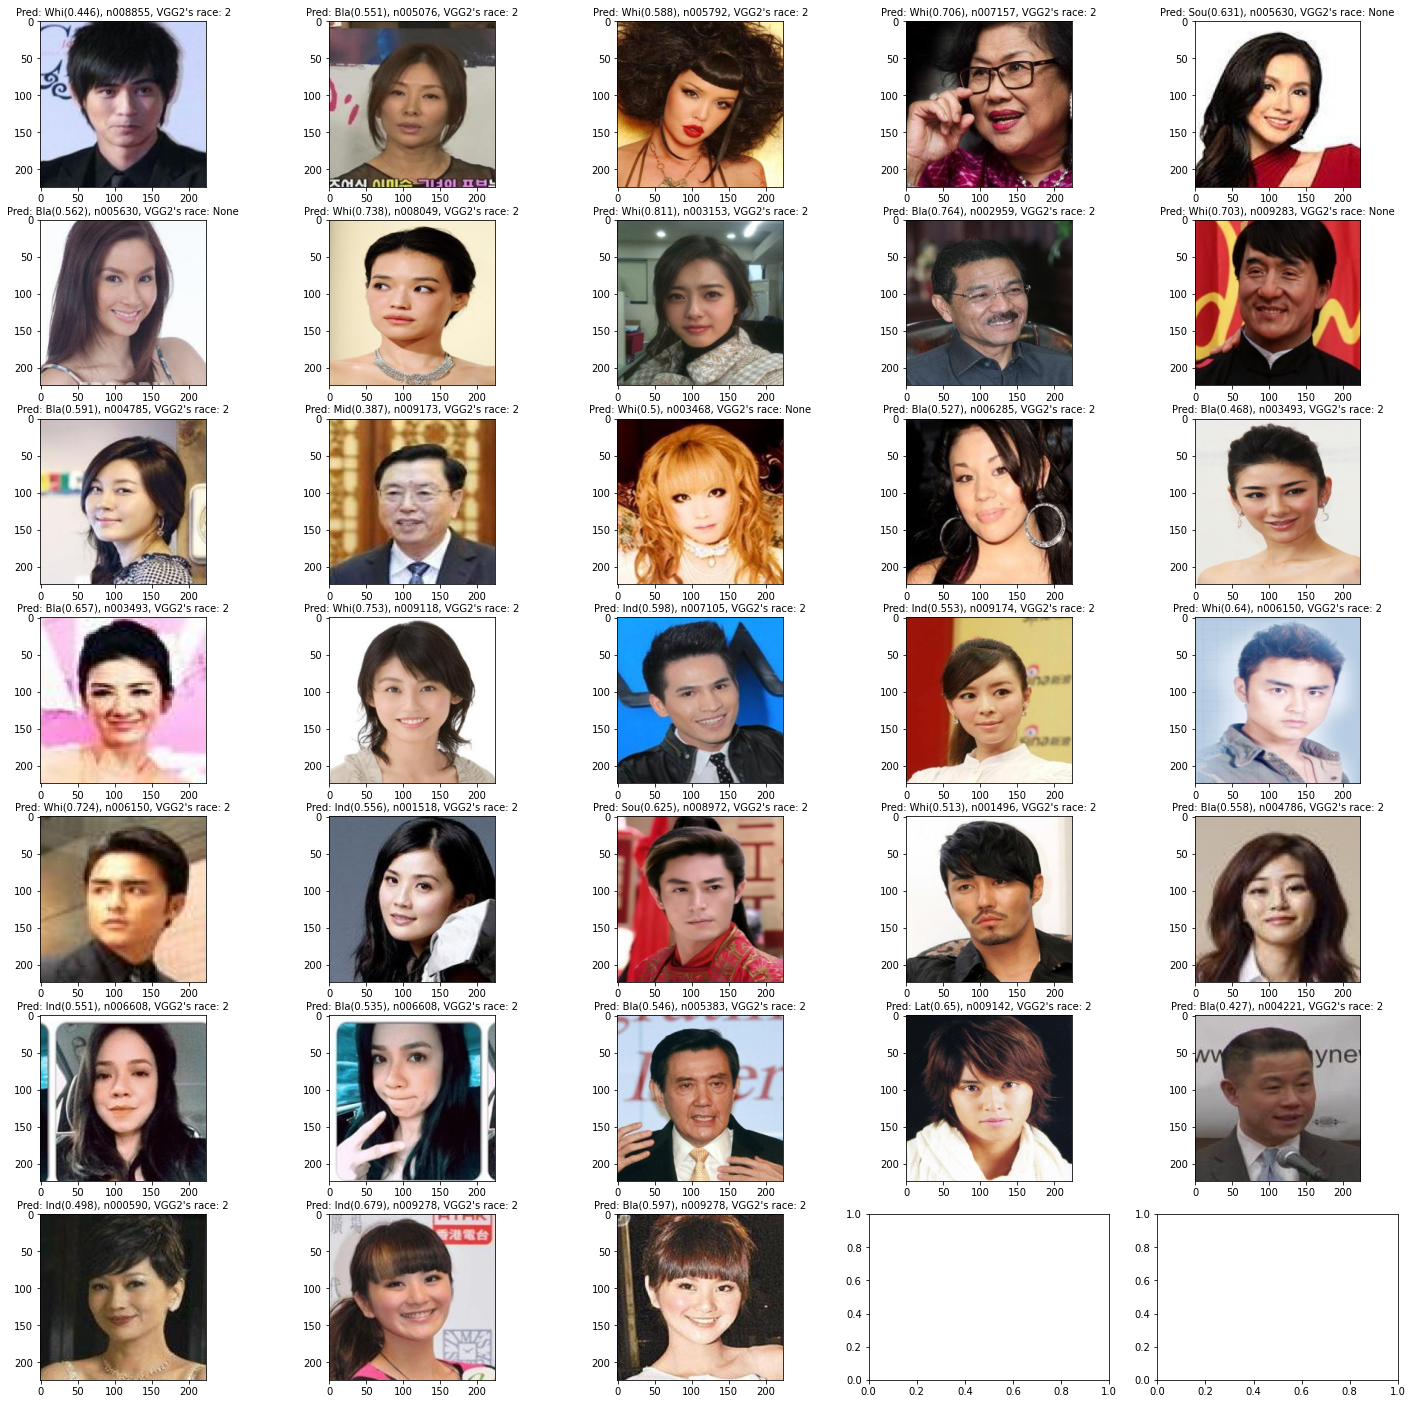

In [ ]:
visualize_face(csv_file, vgg2_train_df, FACE_DIR, BATCH_SIZE, 0)

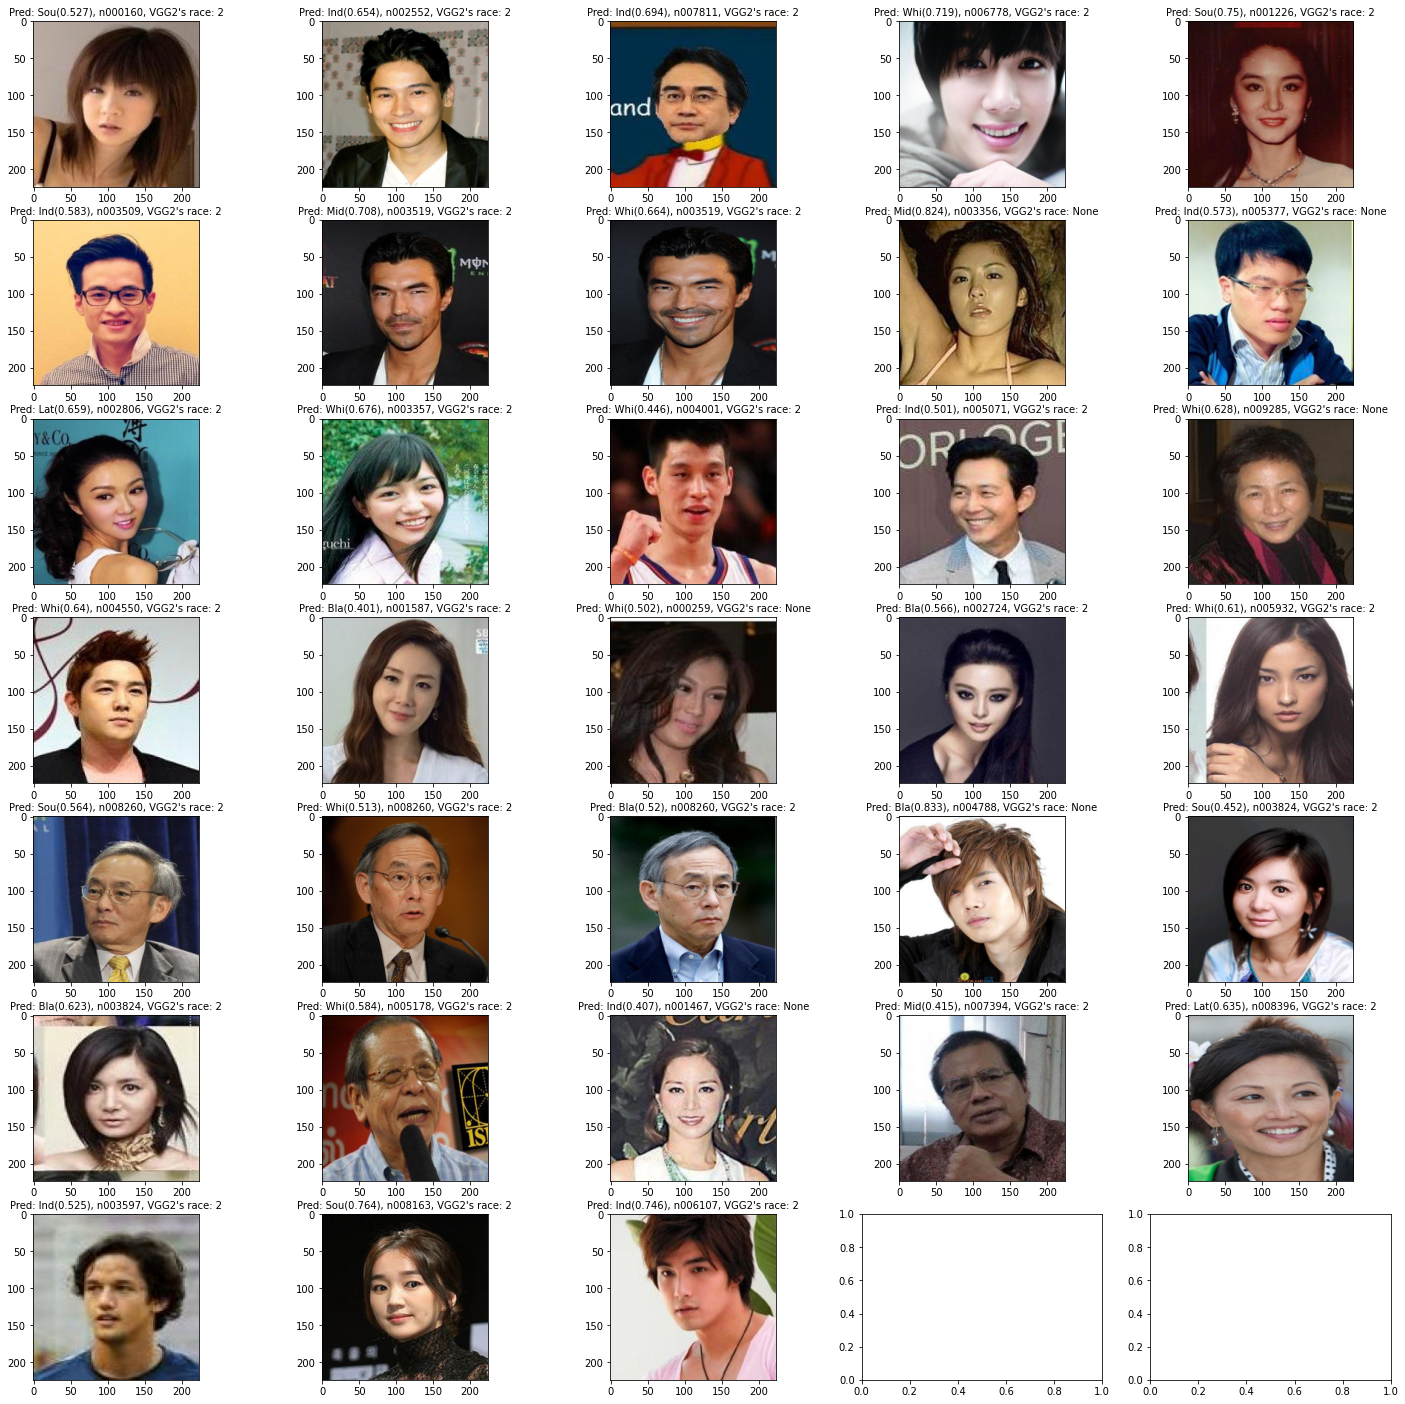

In [ ]:
visualize_face(csv_file, vgg2_train_df, FACE_DIR, BATCH_SIZE, 1)

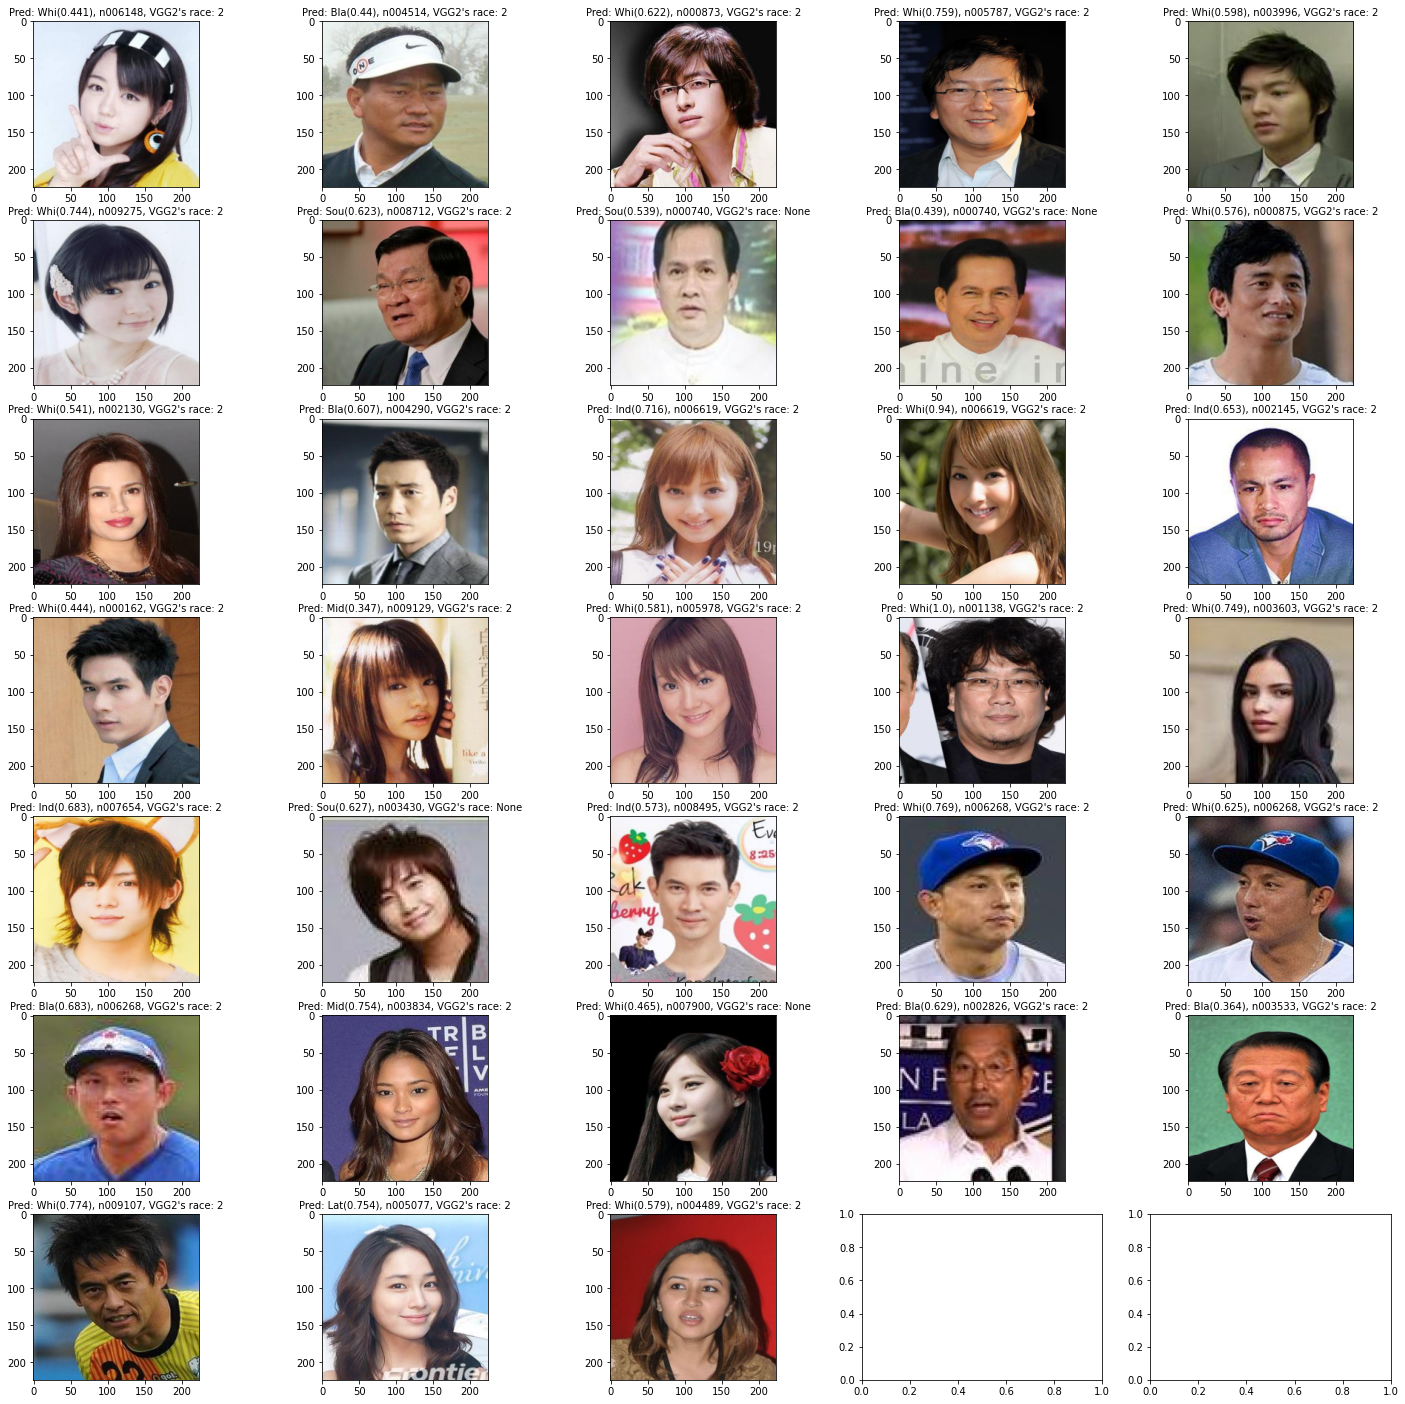

In [ ]:
visualize_face(csv_file, vgg2_train_df, FACE_DIR, BATCH_SIZE, 2)